### Pipeline : analyse de signaux d'ondes gravitationnelles issus du MDC

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from gwpy.plot import Plot
from pycbc.types import FrequencySeries
from pycbc.types import TimeSeries as PycbcTimeSeries
from pycbc import psd as pypsd
from pycbc.inference.models import GaussianNoise
from pycbc.noise.gaussian import frequency_noise_from_psd
from pycbc.waveform.generator import (FDomainDetFrameGenerator,FDomainCBCGenerator)
from pycbc.psd import EinsteinTelescopeP1600143
from pycbc.conversions import mchirp_from_mass1_mass2, q_from_mass1_mass2, mass1_from_mchirp_q, mass2_from_mchirp_q
import generation_signal
from likelihood_calculation import minimisation_locale, minimisation_globale, print_results, likelihood_visualisation
from plot_functions import plot_mnimisation, plot_dual_local_minimisation, plot_correlation, plot_correlation_2_params, plot_correlation_chirp_q
from fonctions import single_plot_spec_GW
from pipeline_fonctions import extraction_data,get_refs,find_ref,filtre_func

### Initialisation :

Donne le temps de début et le temps de fin de la partie du MDC que nous voulons analyser. Le temps de début est $t_0$= 0s et le temps de fin est $t_{\,\text{fin}}$= 2 660 352s.

In [ ]:
t_start = 0
t_stop = 2000

#gggg

# ==================== INIT =======================
path = "/home/shared/et-mdc-frame-files/mdc1/v2/data/E1/"
channel1 = 'E1:STRAIN'
#name_data = "E-E1_STRAIN_DATA-" + number + "-2048.gwf"
dossier_save = "results_test/"
#=================================================

Plot du signal filtré extrait du MDC sur l'échelle de temps choisie initialement :

In [ ]:
ref_start, ref_stop = get_refs(t_start,t_stop)
init_file, final_file = find_ref(ref_start,ref_stop)
print(init_file, final_file)
data = extraction_data(path,init_file[0],final_file[0],channel1,dossier_save,save=False)
hfilt = filtre_func(data)

plot = Plot(hfilt, figsize=[12, 6],
            color='gwpy:ligo-hanford')

#On veut retourner le nombre de signaux et leurs paramètres sur cet intervalle.

Conversion dans le domaine fréquentiel (pour la minimisation) et dans le domaine temporel (pour la visualisation) des données avec pycbc.

[0.00000000e+00 4.88758553e-04 9.77517107e-04 ... 4.09599902e+03
 4.09599951e+03 4.09600000e+03]


(4450000.0, 4520000.0)

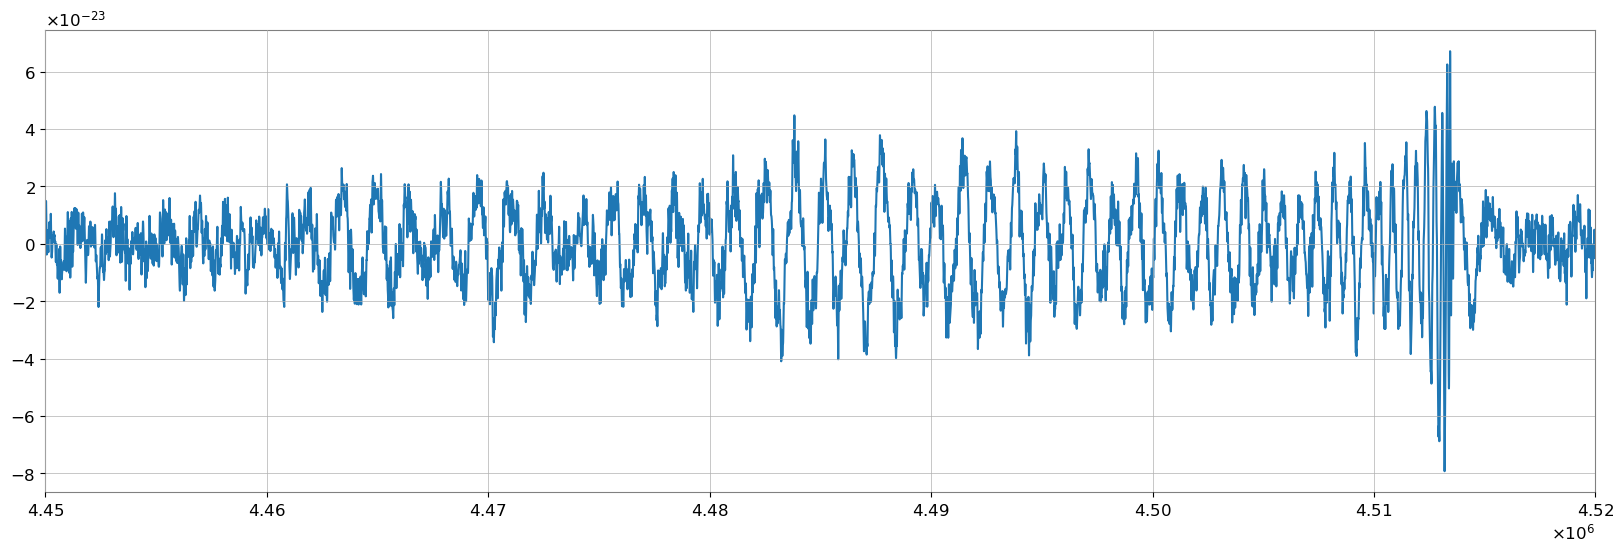

In [ ]:
data = hfilt.value
delta_t = hfilt.dt.value

#On convertit la TimeSerie de gwpy en TimeSerie de pycbc, plus facile à manier et analyser.
pycbc_ts = PycbcTimeSeries(data, delta_t=delta_t) 

#On transforme notre TimeSerie (domaine temporel) en FrequencySerie (domaine fréquentiel).
signal = pycbc_ts.to_frequencyseries()

#print(signal.sample_frequencies) #Afficher les fréquences de la FrequencySerie.

time_s = signal.to_timeseries()
fig, ax = plt.subplots(figsize=(20,6))
ax.plot(time_s)
ax.set_xlim(0.445e7,0.452e7)

In [6]:
from fonctions import extraction_temps

init, final, t0_list, tc_list, interval = extraction_temps(indexes = [0,1], type = 3, print_ = False)
print(t0_list)
print(tc_list)

[1001620399.26659, 1001622646.50307]
[1001620463.11925, 1001622678.23317]


### Minimisation

Text(0, 0.5, 'PSD [1/Hz]')

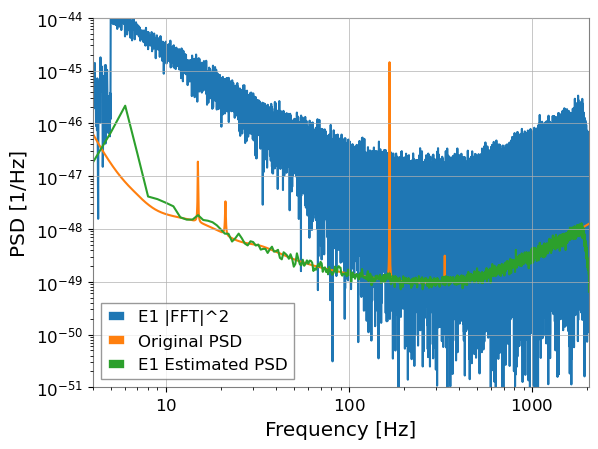

In [3]:
from gwpy.timeseries import TimeSeries
import glob

path_to_MDC_data = {'E1': '/home/victor/Internship_Victor_CBC_ET/MDC_data/loudest_BBH/loudest_E1.gwf',
                    'E2': '/home/victor/Internship_Victor_CBC_ET/MDC_data/loudest_BBH/loudest_E2.gwf',
                    'E3': '/home/victor/Internship_Victor_CBC_ET/MDC_data/loudest_BBH/loudest_E3.gwf'
                    }

ifos=['E1', 'E2', 'E3']
t_start = 1000000000
t_end = 1000000010
data = {}
for ifo in ifos:
    channel = ifo + ':STRAIN'
    files = path_to_MDC_data[ifo]
    #start=t_start, end=t_end
    data[ifo] = TimeSeries.read(files, channel=channel)
    data[ifo] = data[ifo].resample(4096)

# channel1 = 'E1:STRAIN'

# path = "/home/victor/Internship_Victor_CBC_ET/MDC_data/loudest_BBH/loudest_E1.gwf"
# data = TimeSeries.read(path,channel1)
# hfilt = filtre_func(data)

# data = hfilt.value
# delta_t = hfilt.dt.value

# #On convertit la TimeSerie de gwpy en TimeSerie de pycbc, plus facile à manier et analyser.
# pycbc_ts = PycbcTimeSeries(data, delta_t=delta_t) 

# #On transforme notre TimeSerie (domaine temporel) en FrequencySerie (domaine fréquentiel).
# signal = pycbc_ts.to_frequencyseries()

# #print(signal.sample_frequencies) #Afficher les fréquences de la FrequencySerie.

# time_s = signal.to_timeseries()
# fig, ax = plt.subplots(figsize=(20,6))
# ax.plot(time_s)

import sys
  
# adding Folder_2 to the system path
sys.path.insert(0, '/home/victor/Internship_Victor_CBC_ET/code_Adrian/MLE_pipeline/src')


from get_data import read_MDC_data, convert_to_frequency_series_with_psd, convert_data_dict_to_frequency_series_dict


fft, psd = convert_to_frequency_series_with_psd(data['E1'], return_psd=True)
psd_estimated = data['E1'].psd(1.0)
plt.figure()
ax = plt.gca()
ax.loglog(fft.get_sample_frequencies(), np.abs(fft)**2, label='E1 |FFT|^2')
ax.loglog(psd.get_sample_frequencies(), psd, label='Original PSD')
ax.loglog(psd_estimated.frequencies, psd_estimated, label='E1 Estimated PSD')
ax.set_ylim(1e-51, 1e-44)
ax.set_xlim(4, 2048)
ax.legend()
ax.set_xlabel('Frequency [Hz]')
ax.set_ylabel('PSD [1/Hz]')


In [4]:
data_freq, psds = convert_data_dict_to_frequency_series_dict(data)
print(data_freq)
print(psds)

{'E1': <pycbc.types.frequencyseries.FrequencySeries object at 0x7e5b1566a3d0>, 'E2': <pycbc.types.frequencyseries.FrequencySeries object at 0x7e5b152d5a00>, 'E3': <pycbc.types.frequencyseries.FrequencySeries object at 0x7e5b152d5e20>}
{'E1': <pycbc.types.frequencyseries.FrequencySeries object at 0x7e5b18c52310>, 'E2': <pycbc.types.frequencyseries.FrequencySeries object at 0x7e5b1530cd60>, 'E3': <pycbc.types.frequencyseries.FrequencySeries object at 0x7e5b152d5af0>}


In [11]:
from likelihood import MDCGaussianNoise

model = MDCGaussianNoise(data_freq, psds)
log_noise_likelihood_from_SNR = model.lognl

optimal_loglr, optimal_loglikelihood = model.compute_optimal_likelihoods()
print('Optimal log likelihood ratio: ' + format(optimal_loglr, '.2f'))
print('Optimal log likelihood: ' + format(optimal_loglikelihood, '.2f'))

snr_network_sq = model.det_optimal_snrsq('E1') + model.det_optimal_snrsq('E2') + model.det_optimal_snrsq('E3')
print('1/2 network SNR: ' + format(0.5 * snr_network_sq, '.2f'))

True signal parameters unknown. Cannot compute optimal likelihood.
True signal parameters unknown. Cannot compute optimal likelihood.
Optimal log likelihood ratio: -1.00
Optimal log likelihood: -1.00


ValueError: no parameters values currently stored; run update to add some

In [ ]:
res = model.maximize(bounds_method='sensible', max_iterations=100, tol=1e-6)
print(model.maximized_params)
print(model.injection_params)

In [10]:
mass1_init = 30
mass2_init = 30
mchirp = mchirp_from_mass1_mass2(mass1_init,mass2_init)
q = q_from_mass1_mass2(mass1_init,mass2_init)
#true params : (tc=3.1, chirp_mass, q, dist = 1000, ra = 1.37, dec = -1.26, pola=2.76, incl = 0, s1z=0, s2z=0)
initial_params = [2, mchirp, q,   1500,       0,      0,    0,       0,    0,       0]

    
file_name = 'params_glob_norm_L_2.txt'
result_glob = minimisation_globale(model=model,initial_params = initial_params,method="SLSQP",minimisation='differential_evolution',
                                   tol=0.001,nb_iter=100,stepsize = 0.1,log_noise_likelihood_from_SNR=log_noise_likelihood_from_SNR,
                                   normalisation=False,save_data=False,file_name=file_name)
print(result_glob)

min : 0.0017487473605102212, it : 54


KeyboardInterrupt: 